In [1]:
## Bases teóricas

    # A cidade não é uma massa homogênea, heterogeneidade
    # As polĩticas públicas dependem de domĩnios geográficos e atributos simples para seu sucesso
    # Quanto maior a velocidade da via maior a sinistralidade
    # As vias locais tem sinistralidade mais baixa
    

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import libpysal as lps
%matplotlib inline 

In [3]:
n_clusters = 5

In [4]:
df_meip = pd.read_csv('data/df_meip_v_02.csv', sep=';', decimal=',')\
    .set_index('od_id')

In [5]:
gdf_od = gpd.read_file('data/zonas-OD-2017-São-Paulo.gpkg')

In [6]:
df_meip.loc[:, 'atrop_tot'] = df_meip.loc[:, 'atrop_fer'] + df_meip.loc[:, 'atrop_fat']

In [7]:
modelo = [
    "ren_median_f",
    "sin_tot",
    #'atrop_tot',
    "p_atrop_sin",
    "fatalid",
    "atrop_desl",
    "p_atrop_esc",
    "p_atrop_auto",
    "p_atrop_moto",
    "p_atrop_onibus",
    "p_atrop_caminh",
    "p_atrop_bicicl",
    "p_atrop_tr_mo",
    "p_atrop_pri",
    "p_atrop_sec_ter",
    "p_atrop_loc",
    "p_atrop_ati",
    "p_atrop_rur",
    "p_atrop_rap",
    "p_atrop_len",
    "CA_medio",
    "p_n_resid",
    "p_fam_n_motor",
    "p_fx_ped_at",
    "med_calc",
    "dens_ilumi",
    "inters_crit",
    "dem_sem_at_osm",
    "w_CMA_15",
    "w_CMP_15",
    "b_CMA_30",
    "b_CMP_30",
    "pt_CMA_60",
    "pt_CMP_60",
    "c_CMA_60",
    "c_CMP_60",
    "c_CMAS_15",
]

In [8]:
len(modelo)

36

In [9]:
for a in modelo:
    if df_meip[a].dtype == 'object': 
        df_meip[a] = pd.to_numeric(df_meip[a], errors='coerce').fillna(0)
        print(a)
        print(df_meip[a].isna().value_counts())

ren_median_f
False    342
Name: ren_median_f, dtype: int64
dem_sem_at_osm
False    342
Name: dem_sem_at_osm, dtype: int64


In [10]:
df_meip.fillna(0, inplace=True)

In [11]:
wq = lps.weights.Queen.from_dataframe(gdf_od)

In [12]:
wq.transform = 'r'

In [13]:
for m in modelo:
    df_meip[f'{m}_vizinhos'] = lps.weights.lag_spatial(wq, df_meip[m])

In [14]:
modelo_vizinhanca = modelo + [m + "_vizinhos" for m in modelo]

In [15]:
scaler = MinMaxScaler((-1,1))

In [16]:
kmeanModel = KMeans(n_clusters=n_clusters)
kmeanModel.fit(scaler.fit_transform(df_meip[modelo_vizinhanca]))

KMeans(n_clusters=5)

In [17]:
taxonomia = {
    0:"centro sudoeste",
    1:"periferia",
    2:"transição periférica",
    3:"cinturão das marginais",
    4:"centro",
}

In [74]:
sns.set(rc={"figure.figsize":(10, 10)})

<AxesSubplot: >

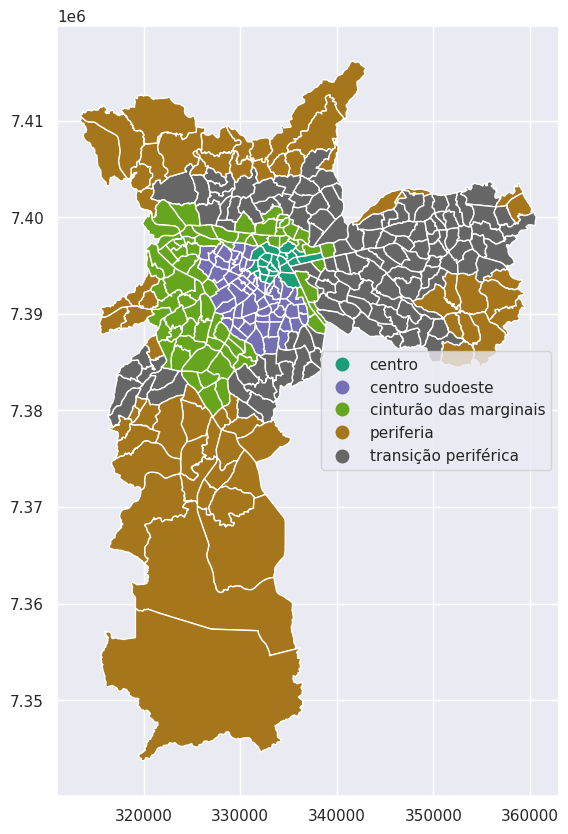

In [75]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaler.fit_transform(df_meip[modelo_vizinhanca]))
df_meip['k_cluster'] = kmeans.labels_
df_meip['k_labels'] = [taxonomia[k] for k in kmeans.labels_]
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')
gdf_zona_merged.plot(column='k_labels', legend=True, categorical=True, legend_kwds={'loc': 'center right'}, cmap='Dark2')

In [20]:
df_meip.loc[:, ['atrop_tot'] + modelo + ['k_cluster', 'k_labels']].set_index('k_labels').groupby('k_labels').quantile(.50).style.background_gradient().format(precision=2)

,atrop_tot,ren_median_f,sin_tot,p_atrop_sin,fatalid,atrop_desl,p_atrop_esc,p_atrop_auto,p_atrop_moto,p_atrop_onibus,p_atrop_caminh,p_atrop_bicicl,p_atrop_tr_mo,p_atrop_pri,p_atrop_sec_ter,p_atrop_loc,p_atrop_ati,p_atrop_rur,p_atrop_rap,p_atrop_len,CA_medio,p_n_resid,p_fam_n_motor,p_fx_ped_at,med_calc,dens_ilumi,inters_crit,dem_sem_at_osm,w_CMA_15,w_CMP_15,b_CMA_30,b_CMP_30,pt_CMA_60,pt_CMP_60,c_CMA_60,c_CMP_60,c_CMAS_15,k_cluster
k_labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
centro,80.00,3044.00,145.00,37.08,2.48,15.00,15.40,21.61,7.69,5.13,0.65,0.43,5.06,12.00,46.58,22.09,1.16,0.00,26.74,23.40,6.83,56.08,63.97,27.78,3.13,27.76,325.00,0.00,20528.00,12493.00,249275.00,213111.00,2511222.00,3593945.00,4887362.00,9475393.00,104.00,4.00
centro sudoeste,27.00,6143.00,82.00,14.34,1.30,5.00,5.42,11.66,3.62,1.49,0.00,0.00,0.00,14.29,33.33,36.00,0.00,0.00,17.14,36.67,5.53,19.68,26.50,20.80,3.07,25.21,326.00,0.00,12010.00,15740.00,311999.00,309762.00,1986184.00,2400110.00,4865763.00,8918022.00,98.00,0.00
cinturão das marginais,33.00,4500.00,163.00,13.85,2.17,6.00,8.69,11.17,5.24,1.75,0.00,0.00,15.79,28.57,23.91,19.57,0.00,0.00,46.30,22.73,3.43,16.23,33.10,14.42,2.50,22.18,480.00,0.00,5218.00,6285.00,84061.00,117193.00,1493188.00,1822632.00,4746415.00,8588398.00,49.00,3.00
periferia,41.00,2453.00,138.00,18.43,3.02,8.00,10.54,11.94,7.18,2.07,0.59,0.00,0.00,6.85,27.27,36.00,0.00,0.00,25.71,39.44,0.72,13.32,48.24,4.31,2.07,24.64,251.00,0.00,1744.00,5413.00,31733.00,102108.00,276365.00,600573.00,2791141.00,6467843.00,16.00,1.00
transição periférica,68.50,2926.50,209.00,28.75,3.12,13.00,14.73,18.59,8.67,2.73,0.57,0.00,0.00,5.82,47.38,30.67,0.00,0.00,15.69,32.11,1.37,14.75,44.01,9.20,2.04,30.16,412.50,0.00,4397.00,13895.00,91960.50,293165.50,800105.00,1527765.50,4032750.00,8510800.50,48.00,2.00


In [21]:
df_meip[[m + "_vizinhos" for m in modelo]]

,ren_median_f_vizinhos,sin_tot_vizinhos,p_atrop_sin_vizinhos,fatalid_vizinhos,atrop_desl_vizinhos,p_atrop_esc_vizinhos,p_atrop_auto_vizinhos,p_atrop_moto_vizinhos,p_atrop_onibus_vizinhos,p_atrop_caminh_vizinhos,...,dem_sem_at_osm_vizinhos,w_CMA_15_vizinhos,w_CMP_15_vizinhos,b_CMA_30_vizinhos,b_CMP_30_vizinhos,pt_CMA_60_vizinhos,pt_CMP_60_vizinhos,c_CMA_60_vizinhos,c_CMP_60_vizinhos,c_CMAS_15_vizinhos
od_id,,,,,,,,,,,,,,,,,,,,,
1,3137.600000,203.800000,60.954000,6.088000,25.400000,26.802000,31.182000,14.396000,11.196000,1.472000,...,0.0,32202.200000,17874.400000,327463.000000,277970.600000,2.685769e+06,4.169024e+06,4.912631e+06,9.424461e+06,132.800000
2,3307.555556,144.333333,35.283333,3.327778,14.333333,14.572222,20.583333,9.234444,5.030000,0.995556,...,0.0,20483.111111,12719.000000,246256.444444,211416.777778,2.488230e+06,3.788773e+06,4.885458e+06,9.525449e+06,104.666667
3,3595.000000,151.833333,39.211667,3.168333,15.666667,15.781667,22.738333,9.256667,5.198333,0.685000,...,0.0,24331.166667,19001.833333,345608.166667,277679.666667,2.456488e+06,3.659284e+06,4.920262e+06,9.435312e+06,132.833333
4,3435.714286,117.000000,34.237143,3.280000,13.000000,15.290000,20.454286,6.685714,5.445714,0.385714,...,0.0,30327.428571,23686.142857,388621.571429,317073.428571,2.503789e+06,3.688076e+06,4.922841e+06,9.346338e+06,139.285714
5,3126.400000,189.400000,50.844000,4.858000,21.000000,22.132000,28.248000,11.326000,8.798000,1.034000,...,0.0,32293.800000,21360.000000,364614.000000,314864.600000,2.594870e+06,3.869865e+06,4.911117e+06,9.283031e+06,135.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,3168.333333,136.500000,11.810000,1.556667,5.333333,7.223333,9.735000,5.096667,0.940000,0.885000,...,0.0,3871.333333,5052.666667,45221.833333,71306.166667,1.126112e+06,9.505837e+05,4.651314e+06,7.866740e+06,28.666667
339,5575.142857,206.857143,14.975714,1.791429,7.000000,8.085714,11.184286,7.001429,1.951429,0.241429,...,0.0,3771.571429,5724.142857,63777.285714,99299.000000,1.494344e+06,1.434941e+06,4.606678e+06,7.775445e+06,41.000000
340,6192.500000,173.166667,11.671667,1.705000,5.166667,7.306667,9.271667,4.355000,2.456667,0.180000,...,0.0,6438.666667,3716.500000,92851.333333,92629.833333,1.762594e+06,1.746023e+06,4.685220e+06,7.970830e+06,49.666667


In [22]:
import pingouin as pg

In [23]:
pg.corr(df_meip["sin_tot"],df_meip["CA_medio"])

,n,r,CI95%,p-val,BF10,power
pearson,342,-0.151357,"[-0.25, -0.05]",0.005031,3.403,0.802916


In [24]:
pg.corr(df_meip["sin_tot"],df_meip["p_fx_ped_at"])

,n,r,CI95%,p-val,BF10,power
pearson,342,-0.163332,"[-0.26, -0.06]",0.002447,6.539,0.859592


In [25]:
sns.set(rc={"figure.figsize":(7, 5)})

<AxesSubplot: xlabel='sin_tot', ylabel='CA_medio'>

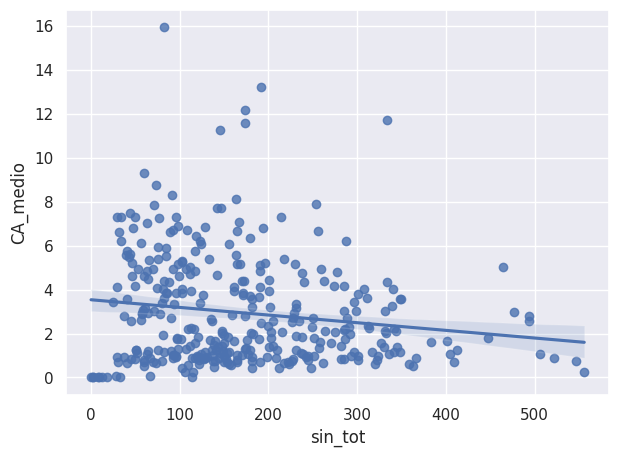

In [26]:
sns.regplot(x=df_meip["sin_tot"], y=df_meip["CA_medio"])

In [27]:
pg.corr(df_meip["atrop_tot"], df_meip["p_fx_ped_at"])
pg.corr(df_meip["fatalid"], df_meip["p_fx_ped_at"])

,n,r,CI95%,p-val,BF10,power
pearson,342,-0.139347,"[-0.24, -0.03]",0.009876,1.862,0.734297


<AxesSubplot: xlabel='atrop_tot', ylabel='p_fx_ped_at'>

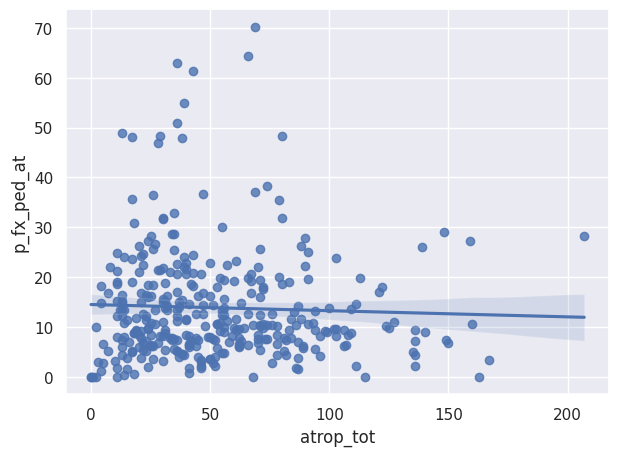

In [28]:
sns.regplot(x=df_meip["atrop_tot"], y=df_meip["p_fx_ped_at"])
#pg.partial_corr(data=df_meip, x='fatalid', y='p_fx_ped_at')

In [29]:
pg.corr(df_meip["fatalid"], df_meip["dem_sem_at_osm"])

,n,r,CI95%,p-val,BF10,power
pearson,342,-0.033517,"[-0.14, 0.07]",0.53675,0.082,0.094738


In [30]:
pg.corr(df_meip["atrop_tot"], df_meip["inters_crit"])

,n,r,CI95%,p-val,BF10,power
pearson,342,0.464755,"[0.38, 0.54]",9.956794e-20,4.924e+16,1.0


<AxesSubplot: xlabel='atrop_tot', ylabel='inters_crit'>

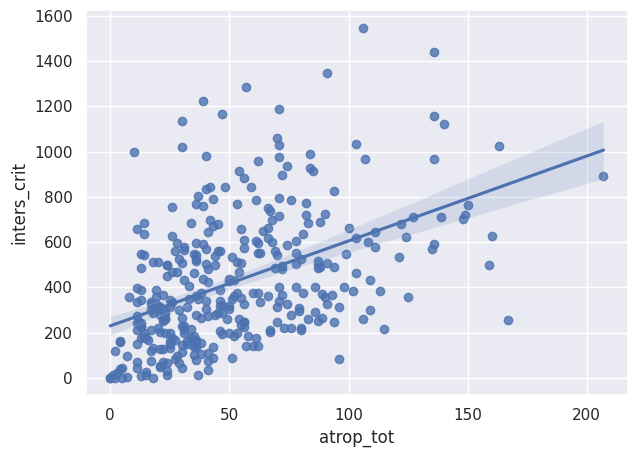

In [31]:
sns.regplot(x=df_meip["atrop_tot"], y=df_meip["inters_crit"])

In [32]:
pg.corr(df_meip["fatalid"], df_meip["CA_medio"])

,n,r,CI95%,p-val,BF10,power
pearson,342,-0.175256,"[-0.28, -0.07]",0.001136,13.2,0.904025


<AxesSubplot: xlabel='atrop_tot', ylabel='inters_crit'>

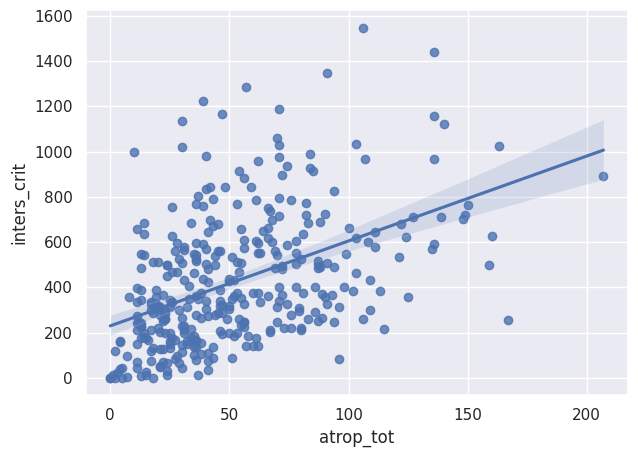

In [33]:
sns.regplot(x=df_meip["atrop_tot"], y=df_meip["inters_crit"])

In [34]:
pg.corr(df_meip["fatalid"], df_meip["pt_CMA_60"])

,n,r,CI95%,p-val,BF10,power
pearson,342,-0.288853,"[-0.38, -0.19]",5.368975e-08,1.682e+05,0.999786


In [35]:
sns.set(rc={"figure.figsize":(7, 5)})

<AxesSubplot: xlabel='ren_median_f', ylabel='fatalid'>

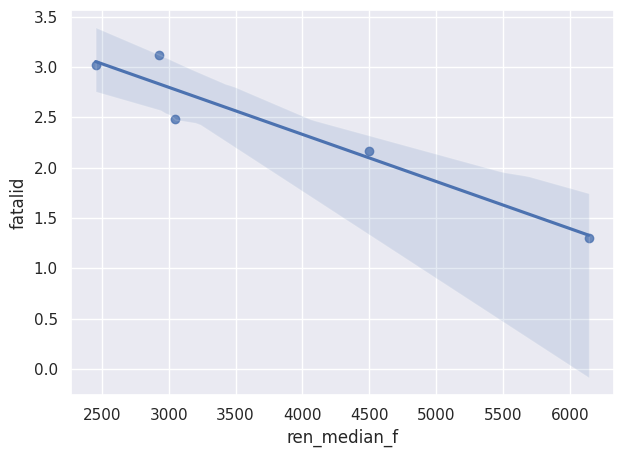

In [36]:
df_clusters = df_meip.loc[:, modelo + ['atrop_tot', 'k_cluster', 'k_labels']].set_index('k_labels').groupby('k_labels').quantile(.50)
sns.regplot(x=df_clusters["ren_median_f"], y=df_clusters["fatalid"])

In [37]:
pg.corr(df_clusters["ren_median_f"], df_clusters["fatalid"])

,n,r,CI95%,p-val,BF10,power
pearson,5,-0.957437,"[-1.0, -0.48]",0.010473,5.7,0.826664


In [38]:
pg.corr(df_meip["ren_median_f"], df_meip["fatalid"])

,n,r,CI95%,p-val,BF10,power
pearson,342,-0.290573,"[-0.38, -0.19]",4.437726e-08,2.021e+05,0.999812


## Correlacao dos grupos

In [39]:
df_clusters.corr()

,ren_median_f,sin_tot,p_atrop_sin,fatalid,atrop_desl,p_atrop_esc,p_atrop_auto,p_atrop_moto,p_atrop_onibus,p_atrop_caminh,...,w_CMP_15,b_CMA_30,b_CMP_30,pt_CMA_60,pt_CMP_60,c_CMA_60,c_CMP_60,c_CMAS_15,atrop_tot,k_cluster
ren_median_f,1.000000,-0.655635,-0.591582,-0.957437,-0.684924,-0.817319,-0.501606,-0.924921,-0.507669,-0.902001,...,0.416608,0.644851,0.411289,0.486942,0.284702,0.640002,0.440873,0.523244,-0.661649,-0.434482
sin_tot,-0.655635,1.000000,0.424039,0.790666,0.566199,0.720506,0.447067,0.787690,0.245683,0.464222,...,-0.183511,-0.650160,-0.104330,-0.401437,-0.239569,-0.205395,-0.040784,-0.452587,0.563521,0.520714
p_atrop_sin,-0.591582,0.424039,1.000000,0.473482,0.985009,0.914759,0.988496,0.761529,0.945444,0.793956,...,0.344202,0.167532,0.254723,0.315470,0.540631,0.125681,0.398009,0.352503,0.987043,0.639054
fatalid,-0.957437,0.790666,0.473482,1.000000,0.602521,0.765348,0.409579,0.926787,0.318323,0.815294,...,-0.390599,-0.763935,-0.332396,-0.646998,-0.452727,-0.682716,-0.488297,-0.655909,0.577776,0.323591
atrop_desl,-0.684924,0.566199,0.985009,0.602521,1.000000,0.967783,0.973536,0.854858,0.896054,0.835736,...,0.266911,0.011354,0.203564,0.174110,0.412207,0.027482,0.309592,0.206503,0.999085,0.647834
p_atrop_esc,-0.817319,0.720506,0.914759,0.765348,0.967783,1.000000,0.890736,0.942759,0.814038,0.865227,...,0.055913,-0.237001,0.019256,-0.021197,0.219386,-0.127873,0.141820,-0.027255,0.963108,0.684567
p_atrop_auto,-0.501606,0.447067,0.988496,0.409579,0.973536,0.890736,1.000000,0.720786,0.914996,0.716663,...,0.444869,0.226497,0.363943,0.368046,0.587072,0.229677,0.501755,0.417672,0.979484,0.631494
p_atrop_moto,-0.924921,0.787690,0.761529,0.926787,0.854858,0.942759,0.720786,1.000000,0.603658,0.910970,...,-0.092185,-0.483397,-0.076603,-0.350500,-0.112233,-0.426963,-0.164581,-0.327490,0.838098,0.483147
p_atrop_onibus,-0.507669,0.245683,0.945444,0.318323,0.896054,0.814038,0.914996,0.603658,1.000000,0.687586,...,0.216076,0.257423,0.078600,0.492979,0.678344,0.237304,0.450925,0.455854,0.904451,0.748451
p_atrop_caminh,-0.902001,0.464222,0.793956,0.815294,0.835736,0.865227,0.716663,0.910970,0.687586,1.000000,...,-0.038060,-0.284896,-0.066298,-0.260142,-0.027931,-0.502133,-0.239145,-0.196110,0.812587,0.337567


## Correlação de atropelamentos com acesso a oportunidades

In [40]:
pg.corr(df_clusters["pt_CMA_60"], df_clusters["fatalid"], )

,n,r,CI95%,p-val,BF10,power
pearson,5,-0.646998,"[-0.97, 0.55]",0.237985,0.968,0.232993


In [41]:
meips = []
for i in range(5):
    print(i)
    k = df_meip.k_cluster == i
    #models.append(np.poly1d(np.polyfit(df_meip[k]["pt_CMA_60"], df_meip[k]["atrop_tot"], 9)))
    meips.append(df_meip.k_cluster == i)

0
1
2
3
4


In [42]:
sns.set(rc={"figure.figsize":(12, 10)})

In [43]:
taxonomia = {
    0:"centro sudoeste",
    1:"periferia",
    2:"transição periférica",
    3:"cinturão das marginais",
    4:"centro",
}

In [44]:
pg.corr(df_meip["pt_CMA_60"], df_meip["atrop_tot"], )

,n,r,CI95%,p-val,BF10,power
pearson,342,-0.103956,"[-0.21, 0.0]",0.054776,0.425,0.485458


<AxesSubplot: xlabel='pt_CMA_60'>

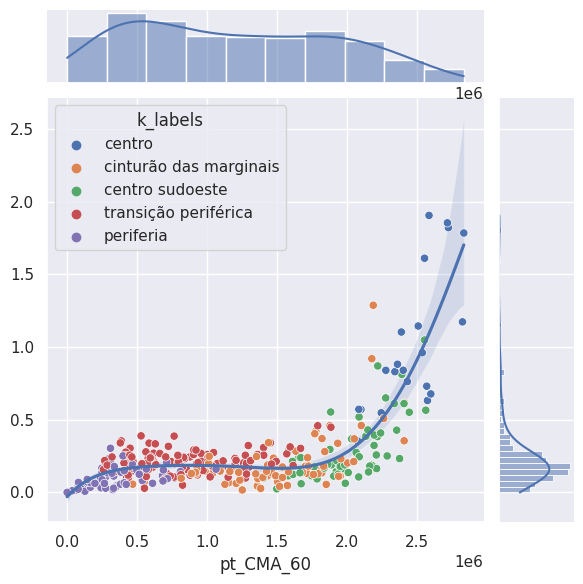

In [45]:
sns.jointplot(x=df_meip["pt_CMA_60"], y=df_meip["atrop_tot"]/df_meip["area_ha"], kind='reg', scatter=False, order=6)
sns.scatterplot(x=df_meip["pt_CMA_60"], y=df_meip["atrop_tot"]/df_meip["area_ha"], hue=df_meip['k_labels'])
#sns.regplot(x=df_meip["pt_CMA_60"], y=df_meip["fatalid"], order=6, c=df_meip['k_cluster'])

<AxesSubplot: xlabel='ren_median_f', ylabel='fatalid'>

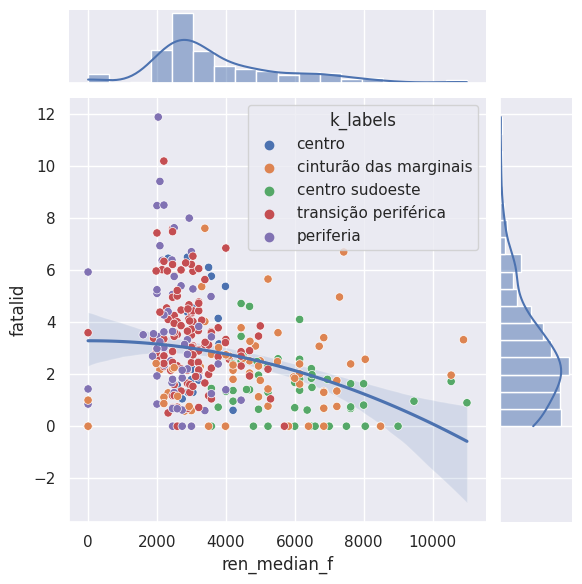

In [64]:
sns.jointplot(x=df_meip["ren_median_f"], y=df_meip["fatalid"], kind='reg', scatter=False, order=2)
sns.scatterplot(x=df_meip["ren_median_f"], y=df_meip["fatalid"], hue=df_meip['k_labels'])


In [46]:
pg.corr(df_clusters["w_CMA_15"], df_clusters["fatalid"] )

,n,r,CI95%,p-val,BF10,power
pearson,5,-0.41721,"[-0.95, 0.74]",0.484632,0.662,0.112931


<AxesSubplot: xlabel='w_CMA_15', ylabel='fatalid'>

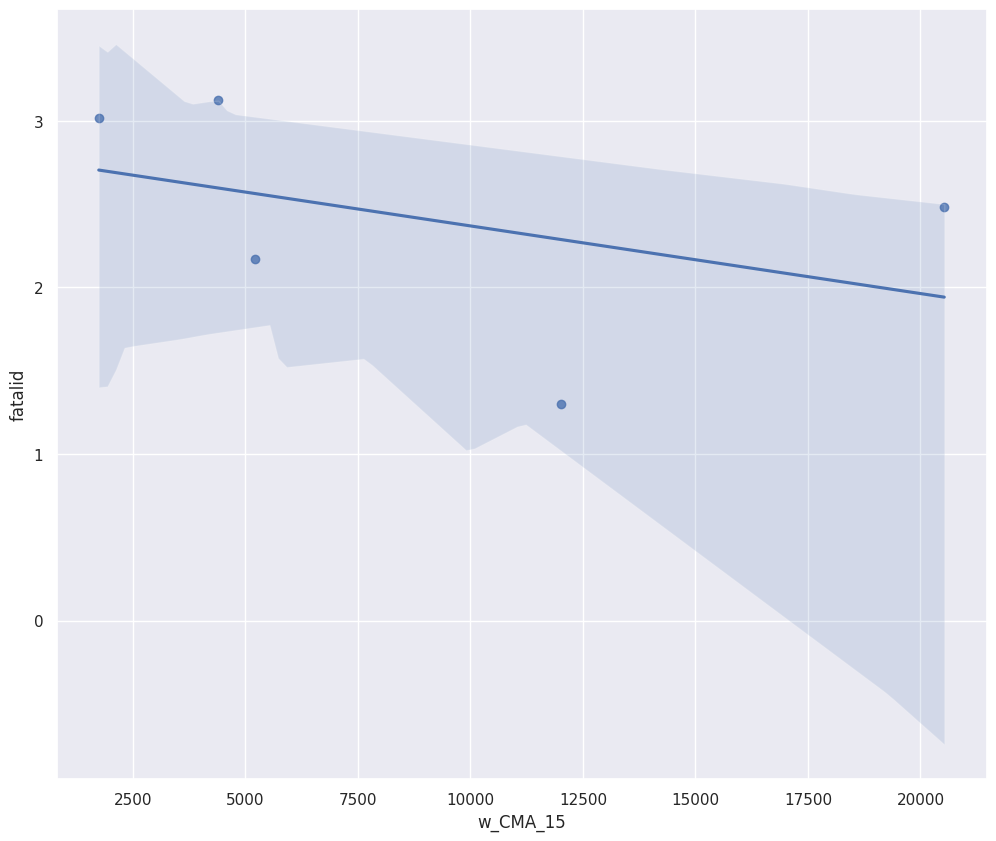

In [47]:
sns.regplot(x=df_clusters["w_CMA_15"], y=df_clusters["fatalid"])

<AxesSubplot: >

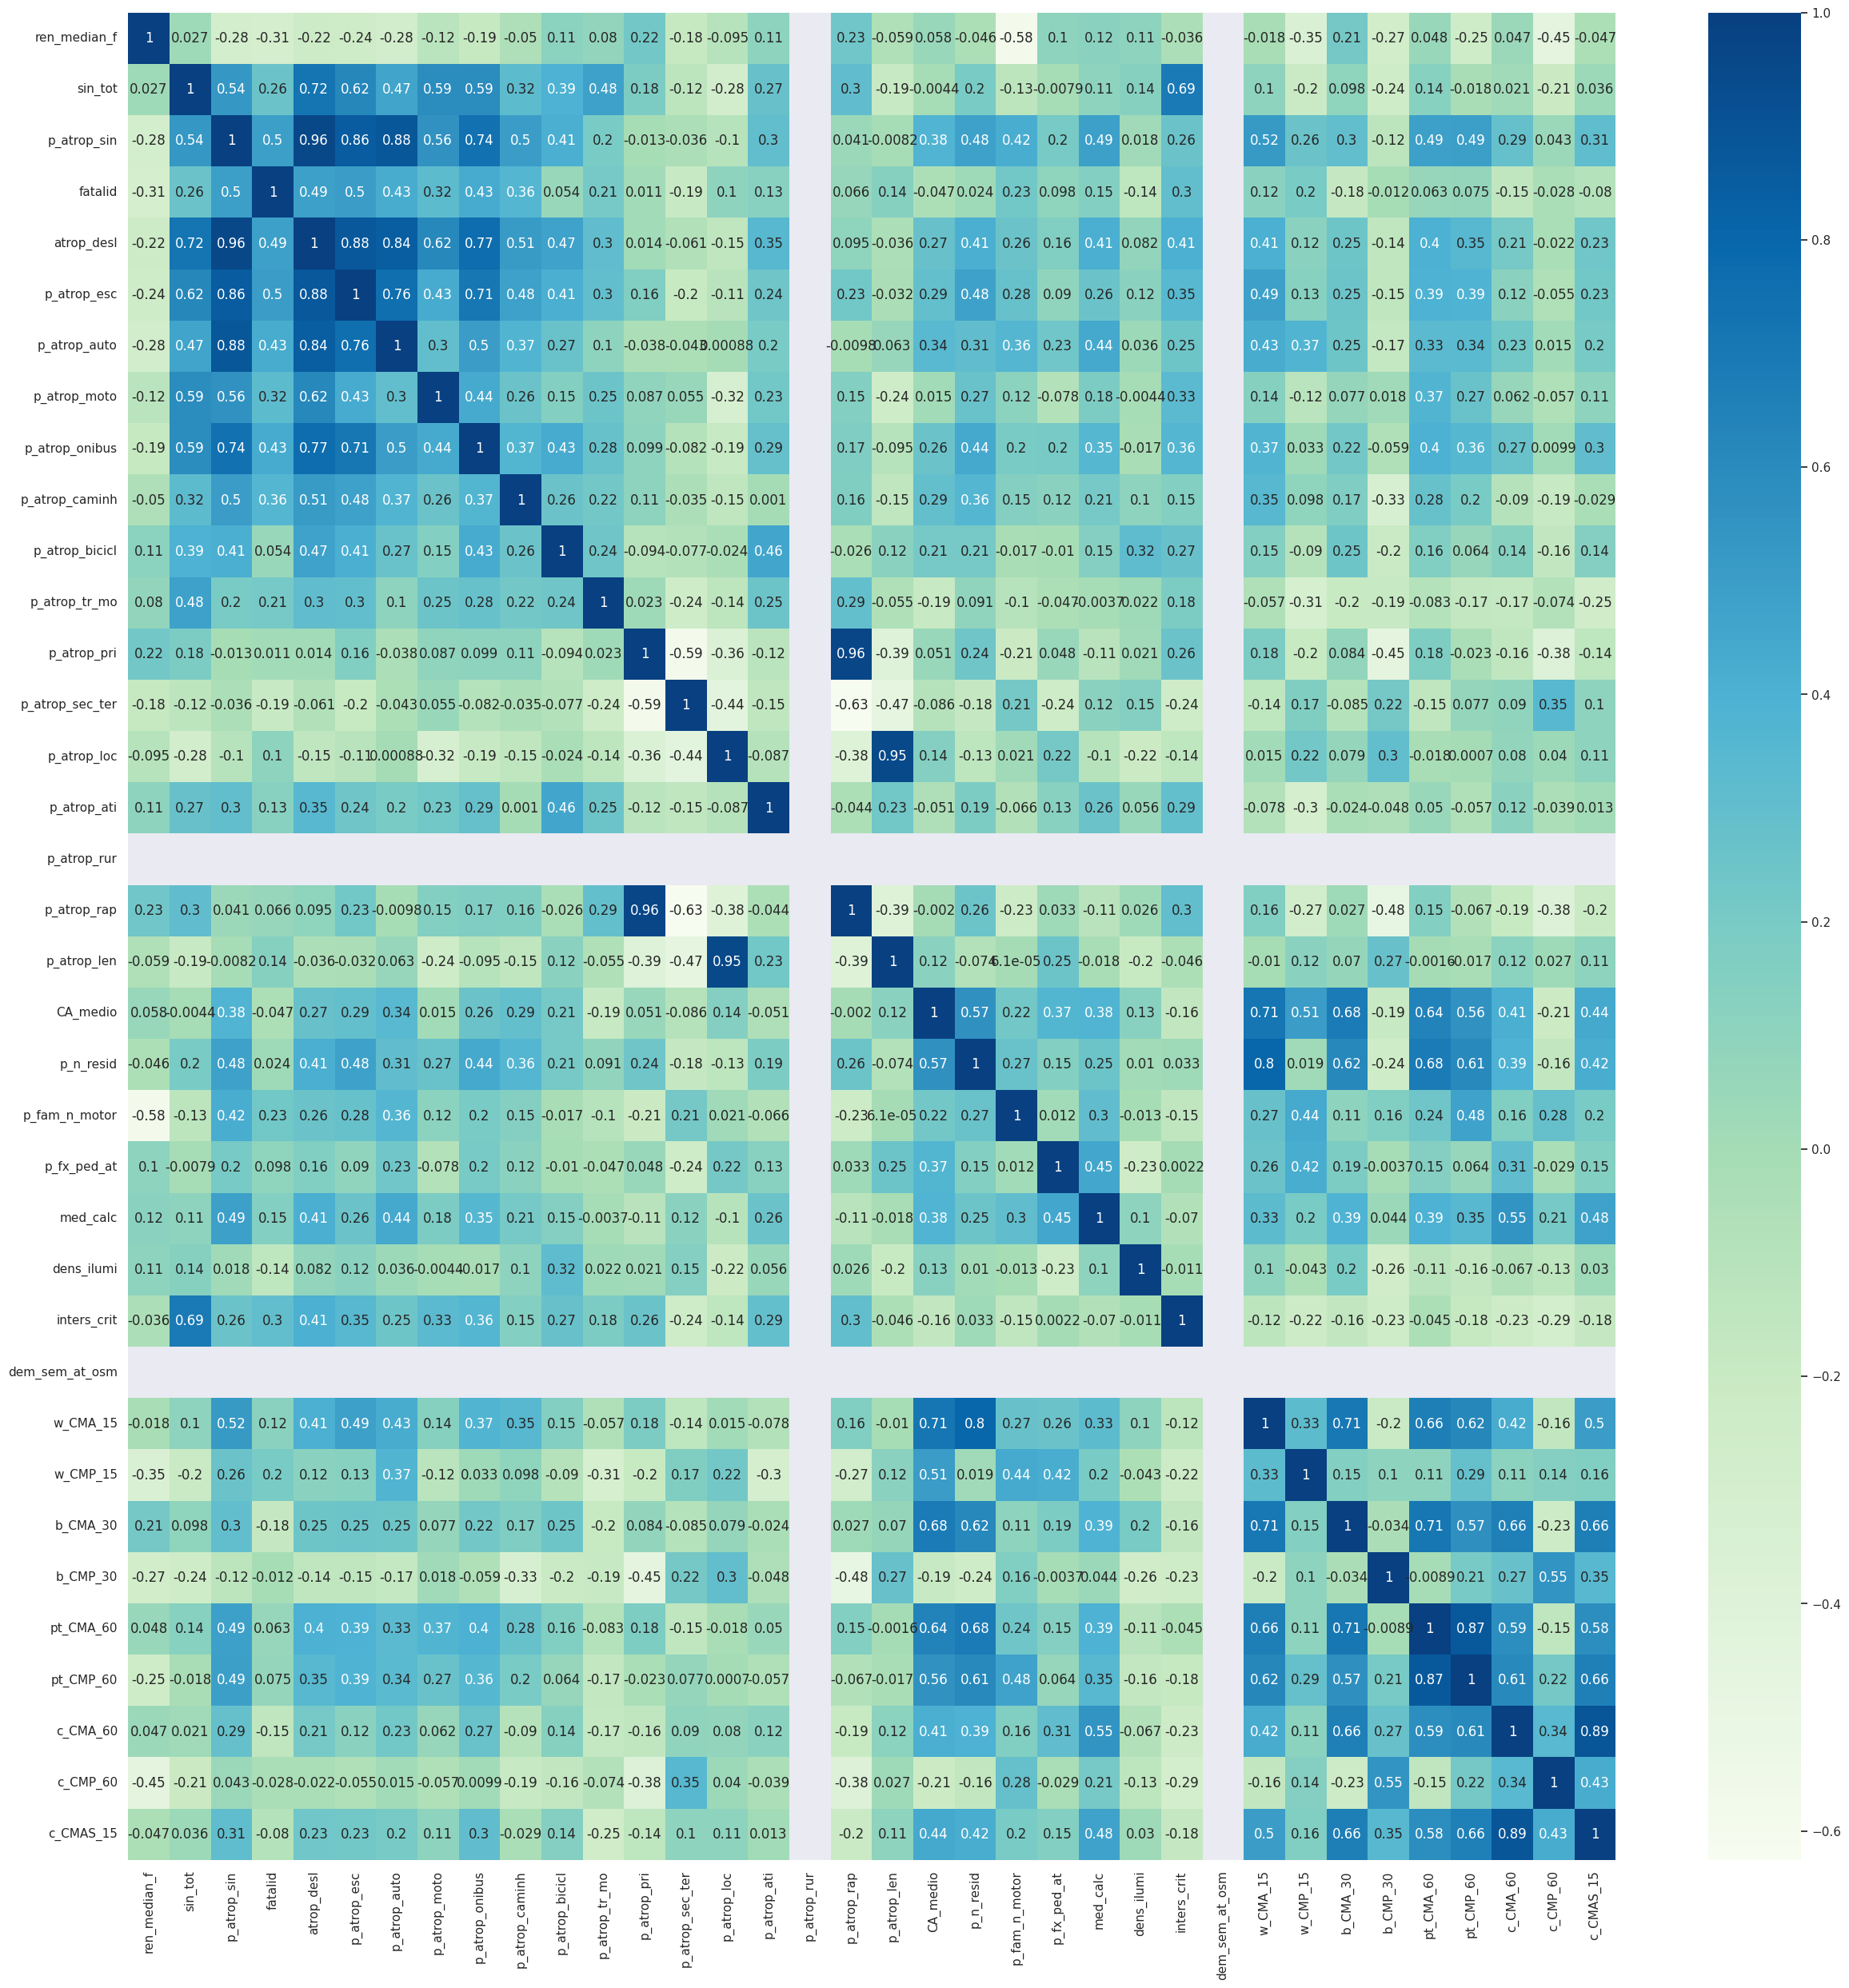

In [48]:
sns.set(rc={"figure.figsize":(30, 30)})
correlacao_modelo = df_meip.loc[df_meip['k_cluster'] == 0, modelo].corr()
sns.heatmap(correlacao_modelo, cmap="GnBu", annot=True)

In [49]:
gdf_zona_merged.columns

Index(['NumeroZona', 'NomeZona', 'NumeroMuni', 'NomeMunici', 'NumDistrit',
       'NomeDistri', 'Area_ha_2', 'geometry', 'od_id', 'nome_od',
       ...
       'w_CMP_15_vizinhos', 'b_CMA_30_vizinhos', 'b_CMP_30_vizinhos',
       'pt_CMA_60_vizinhos', 'pt_CMP_60_vizinhos', 'c_CMA_60_vizinhos',
       'c_CMP_60_vizinhos', 'c_CMAS_15_vizinhos', 'k_cluster', 'k_labels'],
      dtype='object', length=118)

In [50]:
gdf_zona_merged.loc[:, 'area'] = gdf_zona_merged.area

In [51]:
pd.set_option("display.precision", 2)

In [52]:
df_atrop_area = gdf_zona_merged.loc[:, ['k_labels', 'atrop_tot', 'area_ha']].groupby(by='k_labels').sum()

In [53]:
df_atrop_area

,atrop_tot,area_ha
k_labels,,
centro,1861,1996.37
centro sudoeste,1745,7498.55
cinturão das marginais,2682,17027.14
periferia,3229,85033.85
transição periférica,8425,40897.73


In [54]:
df_atrop_area['atrop_tot'] / df_atrop_area['area_ha']

k_labels
centro                    0.93
centro sudoeste           0.23
cinturão das marginais    0.16
periferia                 0.04
transição periférica      0.21
dtype: float64

In [55]:
gdf_zona_merged.dissolve(by='k_cluster')

,geometry,NumeroZona,NomeZona,NumeroMuni,NomeMunici,NumDistrit,NomeDistri,Area_ha_2,od_id,nome_od,...,w_CMP_15_vizinhos,b_CMA_30_vizinhos,b_CMP_30_vizinhos,pt_CMA_60_vizinhos,pt_CMP_60_vizinhos,c_CMA_60_vizinhos,c_CMP_60_vizinhos,c_CMAS_15_vizinhos,k_labels,area
k_cluster,,,,,,,,,,,,,,,,,,,,,
0,"POLYGON Z ((328918.026 7388157.655 0.000, 3289...",19,Cambuci,36,São Paulo,14,Cambuci,140.43,19,Cambuci,...,14846.50,255027.50,307487.00,1.83e+06,2.39e+06,4.88e+06,9.38e+06,109.00,centro sudoeste,1.40e+06
1,MULTIPOLYGON Z (((320063.569 7364134.850 0.000...,112,Jardim Mutinga,36,São Paulo,73,São Domingos,411.97,112,Jardim Mutinga,...,4615.60,24297.40,66099.80,3.75e+05,5.80e+05,3.94e+06,7.74e+06,19.40,periferia,4.11e+06
2,MULTIPOLYGON Z (((332191.994 7378950.602 0.000...,43,Mooca,36,São Paulo,54,Mooca,271.79,43,Mooca,...,11241.11,137936.44,178984.56,1.86e+06,2.84e+06,4.77e+06,9.66e+06,75.22,transição periférica,2.71e+06
3,MULTIPOLYGON Z (((323901.200 7384069.385 0.000...,8,Bom Retiro,36,São Paulo,9,Bom Retiro,143.01,8,Bom Retiro,...,9514.86,178429.71,164294.14,2.03e+06,2.69e+06,4.83e+06,9.26e+06,87.57,cinturão das marginais,1.43e+06
4,"POLYGON Z ((333724.523 7393944.744 0.000, 3337...",1,Sé,36,São Paulo,80,Sé,57.10,1,Sé,...,17874.40,327463.00,277970.60,2.69e+06,4.17e+06,4.91e+06,9.42e+06,132.80,centro,5.70e+05


In [56]:
gdf_zona_merged.to_file('resultados/k_clusters.gpkg')